## This notebook is part of Hadoop and Spark training delivered by IT-DB group
### SPARK DataFrame2 Hands-On Lab
*by Prasanth Kothuri*

### Objective: Perform Basic DataFrame Operations
1. Creating DataFrames
2. Display schema and columns
3. Repartition and Coalesce
4. Create temporary view of the dataframe and issue SQL queries
5. Interplay between spark and python (matplotlib)
    1. Perform the aggregations on the Spark cluster
    2. Collect the aggregated data in the Spark driver
    3. Plot with matplotlib

#### First lets create spark session  (spark), the entry point to programming Spark with the DataFrame and SQL API

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local[*]") \
        .appName("DataFrame HandsOn 2") \
        .config("spark.driver.memory", "4g") \
        .getOrCreate()

#### Load the whitehouse vistor records parquet file into DataFrame

In [3]:
wh_df = spark.read.parquet("../data/WH_VR.parquet")

#### Print the schema to understand the layout

In [4]:
wh_df.printSchema()

root
 |-- NAMELAST: string (nullable = true)
 |-- NAMEFIRST: string (nullable = true)
 |-- NAMEMID: string (nullable = true)
 |-- UIN: string (nullable = true)
 |-- BDGNBR: string (nullable = true)
 |-- ACCESS_TYPE: string (nullable = true)
 |-- TOA: string (nullable = true)
 |-- APPT_MADE_DATE: string (nullable = true)
 |-- APPT_START_DATE: date (nullable = true)
 |-- APPT_END_DATE: string (nullable = true)
 |-- APPT_CANCEL_DATE: string (nullable = true)
 |-- Total_People: string (nullable = true)
 |-- LAST_UPDATEDBY: string (nullable = true)
 |-- POST: string (nullable = true)
 |-- LASTENTRYDATE: string (nullable = true)
 |-- TERMINAL_SUFFIX: string (nullable = true)
 |-- visitee_namelast: string (nullable = true)
 |-- visitee_namefirst: string (nullable = true)
 |-- MEETING_LOC: string (nullable = true)
 |-- MEETING_ROOM: string (nullable = true)
 |-- CALLER_NAME_LAST: string (nullable = true)
 |-- CALLER_NAME_FIRST: string (nullable = true)
 |-- description: string (nullable = true

#### Get number of partitions of the dataframe

In [6]:
wh_df.rdd.getNumPartitions()

16

#### Repartition (incurs shuffle of data), however it is necessary sometimes

In [15]:
df_p = wh_df.repartition(32)
df_p.rdd.getNumPartitions()

32

In [16]:
# If you will be filtering by a certain column often, it can be worth repartitioning based on that column
df_p = wh_df.repartition(32, "NAMELAST")
df_p.rdd.getNumPartitions()

32

#### Filter the orginal dataframe and repartitioned dataframe to observe the performance difference

In [22]:
%%time
wh_df.filter("NAMELAST = 'KOTHURI'").toPandas()

CPU times: user 317 ms, sys: 170 ms, total: 487 ms
Wall time: 6.23 s


NAMELAST         NAMEFIRST NAMEMID     UIN BDGNBR ACCESS_TYPE TOA  \
0  KOTHURI           KRISHNA       K  U17402                 VA       
1  KOTHURI           LAKSHMI       P  U17402                 VA       
2  KOTHURI      RAJYALAKSHMI          U17402                 VA       
3  KOTHURI             SARYU       L  U17402                 VA       
4  KOTHURI  VENKATAGOPALARAO          U17402                 VA       

           APPT_MADE_DATE APPT_START_DATE  APPT_END_DATE  ...  LASTENTRYDATE  \
0  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
1  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
2  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
3  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 12:22   
4  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   

  TERMINAL_SUFFIX visitee_namelast visitee_namefirst MEETING_LOC MEETING_ROOM  \
0              MB           OFFICE          VISITORS          WH    RESIDENCE   
1              MB           OFFICE          VISITORS          WH    RESIDENCE   
2              MB           OFFICE          VISITORS          WH    RESIDENCE   
3              MB           OFFICE          VISITORS          WH    RESIDENCE   
4              MB           OFFICE          VISITORS          WH    RESIDENCE   

  CALLER_NAME_LAST CALLER_NAME_FIRST description                  RELEASE_DATE  
0           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
1           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
2           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
3           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
4           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  

[5 rows x 24 columns]

In [23]:
%%time
df_p.filter("NAMELAST = 'KOTHURI'").toPandas()

CPU times: user 15.2 ms, sys: 5.36 ms, total: 20.6 ms
Wall time: 4.55 s


NAMELAST         NAMEFIRST NAMEMID     UIN BDGNBR ACCESS_TYPE TOA  \
0  KOTHURI           KRISHNA       K  U17402                 VA       
1  KOTHURI           LAKSHMI       P  U17402                 VA       
2  KOTHURI      RAJYALAKSHMI          U17402                 VA       
3  KOTHURI             SARYU       L  U17402                 VA       
4  KOTHURI  VENKATAGOPALARAO          U17402                 VA       

           APPT_MADE_DATE APPT_START_DATE  APPT_END_DATE  ...  LASTENTRYDATE  \
0  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
1  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
2  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   
3  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 12:22   
4  09/17/2014 12:00:00 AM      2014-09-27  9/27/14 23:59  ...  9/17/14 14:56   

  TERMINAL_SUFFIX visitee_namelast visitee_namefirst MEETING_LOC MEETING_ROOM  \
0              MB           OFFICE          VISITORS          WH    RESIDENCE   
1              MB           OFFICE          VISITORS          WH    RESIDENCE   
2              MB           OFFICE          VISITORS          WH    RESIDENCE   
3              MB           OFFICE          VISITORS          WH    RESIDENCE   
4              MB           OFFICE          VISITORS          WH    RESIDENCE   

  CALLER_NAME_LAST CALLER_NAME_FIRST description                  RELEASE_DATE  
0           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
1           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
2           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
3           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  
4           OFFICE          VISITORS  GROUP TOUR  12/29/2014 08:00:00 AM +0000  

[5 rows x 24 columns]

#### Coalesce will not incur a full shuffle and will try to combine partitions (on the same node)

In [26]:
df_c=df_p.coalesce(16)
df_c.rdd.getNumPartitions()

16

#### persist the DataFrame as temporary table

In [27]:
wh_df.createOrReplaceTempView("Vistor_Records")

#### You can now use issue the queries against this table (Vistor_Records) using sql interface
*Count the vistors by last name*

In [28]:
count_by_name = spark.sql("select NAMELAST, count(1) as count from Vistor_Records group by NAMELAST order by count desc")

In [29]:
count_by_name.show()

+--------+-----+
|NAMELAST|count|
+--------+-----+
|   Smith|25908|
| Johnson|21491|
|Williams|18228|
|   Brown|16804|
|   Jones|16023|
|   SMITH|14565|
|  Miller|12942|
|   Davis|12263|
| JOHNSON|12157|
|     Lee|10151|
|WILLIAMS|10147|
|   BROWN| 9847|
|   JONES| 9269|
|Anderson| 9064|
|  Thomas| 8779|
|  Wilson| 8604|
|  Taylor| 8242|
| Jackson| 8146|
|Thompson| 7911|
|   Moore| 7855|
+--------+-----+
only showing top 20 rows



*count the number of vistors by year*

In [30]:
count_by_day = spark.sql("select year(APPT_START_DATE), count(1) as count from Vistor_Records \
    where APPT_START_DATE is not null \
    group by year(APPT_START_DATE) \
    order by year(APPT_START_DATE)").collect()

In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


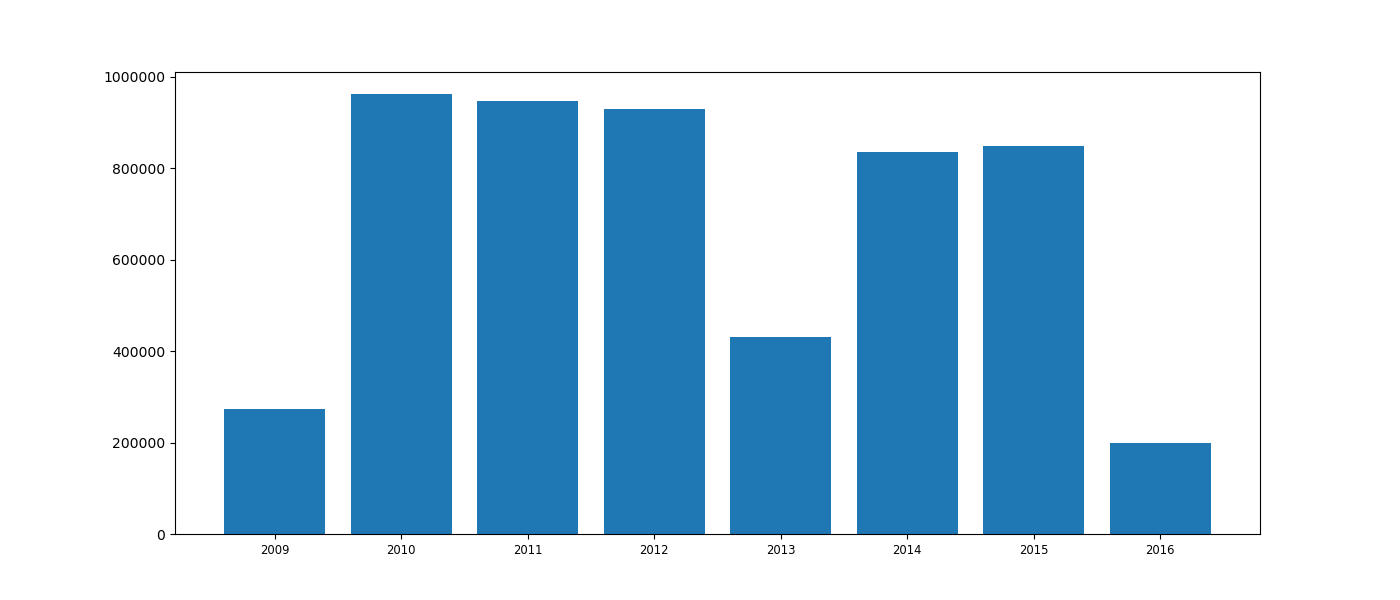

In [32]:
plt.figure(figsize=(14,6))
x_val = [x[0] for x in sorted(count_by_day)]
y_val = [x[1] for x in sorted(count_by_day)]
plt.bar(range(len(y_val)), y_val)
plt.xticks(range(len(x_val)), x_val, size='small')
plt.show()

#### Finally lets produce histogram on the group size

In [33]:
group_size = spark.sql("select distinct UIN, Total_People from Vistor_Records \
    where Total_People > 30 \
    and Total_People < 200").collect()

<IPython.core.display.Javascript object>


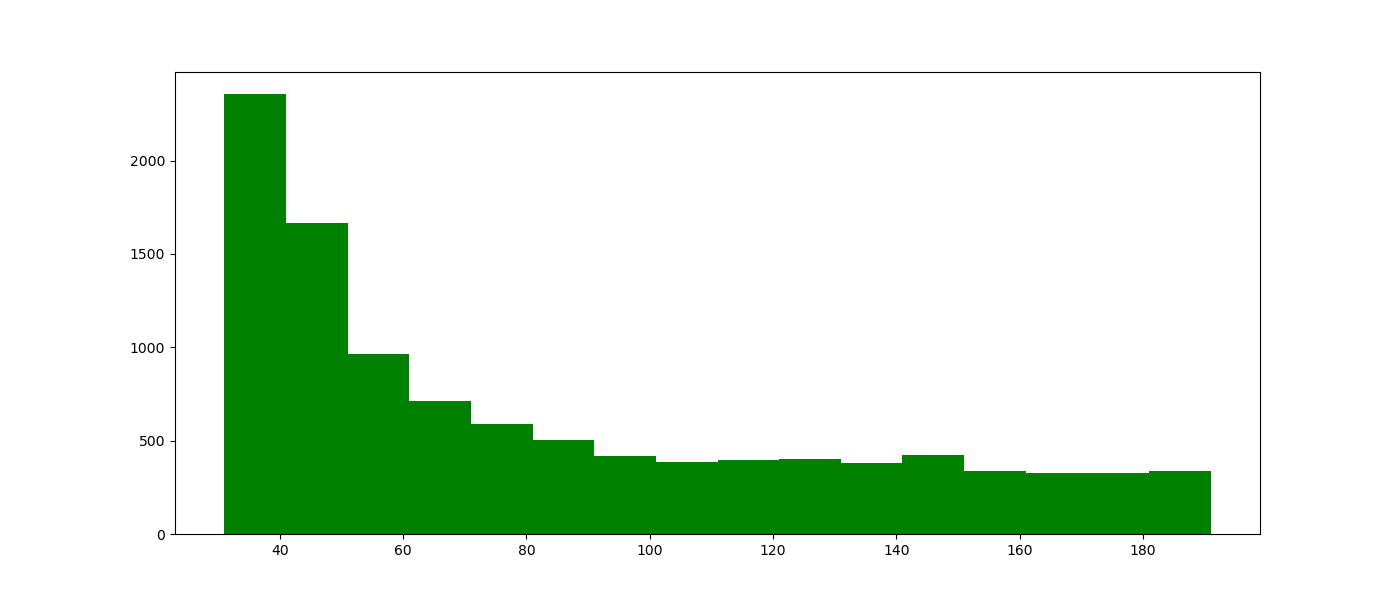

31 199


In [34]:
import numpy as np
plt.figure(figsize=(14,6))
x_val = [int(x[1]) for x in group_size]
print min(x_val),max(x_val)
bins = np.arange(min(x_val), max(x_val), 10) 
n, bins, patches = plt.hist(x_val, bins=bins, facecolor='green')